<div class="alert alert-block alert-success">
<h3><center style="line-height: 1">MSDS-422: Practical Machine Learning</center></h3>
<h1><center style="line-height: 1">Final Project: Group 5</center></h1>
<h2><center style="line-height: 1">Identifying Malware in Network Traffic with Supervised Learning</center></h2>

<b>Group 5</b>:
<ul>
    <li>Aishwarya Mathuria</li>
    <li>Akshaya Venkat Raman</li>
    <li>Tanmay Swami</li>
    <li>Yatika Taneja</li>
</ul>
</div>

In [289]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import glob
from datetime import datetime
import ipaddress
from collections import Counter
from scipy import stats
import os
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Load Dataset</h1>
</div>

In [291]:
# Load all CSV files without any cleaning
print("LOADING RAW DATA")

csv_files = glob.glob('data/*.csv')
print(f"Found {len(csv_files)} CSV files:")
for file in sorted(csv_files):
    size_mb = Path(file).stat().st_size / (1024 * 1024)
    print(f"  - {file}: {size_mb:.2f} MB")

all_dataframes = []

for file in csv_files:
    try:
        print(f"Loading {file}...")
        df = pd.read_csv(file, sep='|')
        df['source_file'] = Path(file).stem
        all_dataframes.append(df)
        print(f"  - Loaded {len(df)} records")
    except Exception as e:
        print(f"Error loading {file}: {e}")

if not all_dataframes:
    raise ValueError("No data files could be loaded")

df = pd.concat(all_dataframes, ignore_index=True)
print(f"\nCombined raw dataset shape: {df.shape}")


numeric_cols = ['duration', 'orig_bytes', 'resp_bytes', 'orig_pkts', 'resp_pkts', 'orig_ip_bytes', 'resp_ip_bytes']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

LOADING RAW DATA
Found 1 CSV files:
  - data/CTU-IoT-Malware-Capture-8-1conn.log.labeled.csv: 1.27 MB
Loading data/CTU-IoT-Malware-Capture-8-1conn.log.labeled.csv...
  - Loaded 10403 records

Combined raw dataset shape: (10403, 24)


<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Exploratory Data Analysis</h1>
</div>

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Basic dataset Information</h3>
</div>

In [294]:
print("\n")
print(f"Total records: {len(df)}")
print(f"Total columns: {len(df.columns)}")
print(f"Shape: {df.shape}")
df.info(memory_usage='deep')
print("\n")



Total records: 10403
Total columns: 24
Shape: (10403, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10403 entries, 0 to 10402
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ts              10403 non-null  float64
 1   uid             10403 non-null  object 
 2   id.orig_h       10403 non-null  object 
 3   id.orig_p       10403 non-null  int64  
 4   id.resp_h       10403 non-null  object 
 5   id.resp_p       10403 non-null  int64  
 6   proto           10403 non-null  object 
 7   service         10403 non-null  object 
 8   duration        4218 non-null   float64
 9   orig_bytes      4218 non-null   float64
 10  resp_bytes      4218 non-null   float64
 11  conn_state      10403 non-null  object 
 12  local_orig      10403 non-null  object 
 13  local_resp      10403 non-null  object 
 14  missed_bytes    10403 non-null  int64  
 15  history         10403 non-null  object 
 16  orig_pkts       

In [295]:
df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed-label,source_file
0,1.533043e+09,C5JLGOoxIw2dBZt47,192.168.100.113,123,81.2.254.224,123,udp,-,0.005490,48.0,...,0,Dd,1,76,1,76,-,Benign,-,CTU-IoT-Malware-Capture-8-1conn.log.labeled
1,1.533043e+09,Cf3cHf4jZr9nvD808i,192.168.100.113,123,147.231.100.5,123,udp,-,0.001741,48.0,...,0,Dd,1,76,1,76,-,Benign,-,CTU-IoT-Malware-Capture-8-1conn.log.labeled
2,1.533043e+09,CJgmSt3bSY6XwE9fzc,192.168.100.113,123,31.31.74.35,123,udp,-,0.004495,48.0,...,0,Dd,1,76,1,76,-,Benign,-,CTU-IoT-Malware-Capture-8-1conn.log.labeled
3,1.533043e+09,Cav32m4csR3OZYhShj,192.168.100.113,123,147.251.48.140,123,udp,-,0.006988,48.0,...,0,Dd,1,76,1,76,-,Benign,-,CTU-IoT-Malware-Capture-8-1conn.log.labeled
4,1.533043e+09,ClwPfA40tU9UT4nksg,192.168.100.113,123,147.231.100.5,123,udp,-,0.001487,48.0,...,0,Dd,1,76,1,76,-,Benign,-,CTU-IoT-Malware-Capture-8-1conn.log.labeled


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Columns</h3>
</div>

In [297]:
print("Columns:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")

Columns:
    1. ts
    2. uid
    3. id.orig_h
    4. id.orig_p
    5. id.resp_h
    6. id.resp_p
    7. proto
    8. service
    9. duration
   10. orig_bytes
   11. resp_bytes
   12. conn_state
   13. local_orig
   14. local_resp
   15. missed_bytes
   16. history
   17. orig_pkts
   18. orig_ip_bytes
   19. resp_pkts
   20. resp_ip_bytes
   21. tunnel_parents
   22. label
   23. detailed-label
   24. source_file


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Data types</h3>
</div>

In [299]:
print(df.dtypes.value_counts())

object     13
int64       7
float64     4
Name: count, dtype: int64


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Missing values</h3>
</div>

,MissingValues,Percent
duration,6185,59.45
orig_bytes,6185,59.45
resp_bytes,6185,59.45


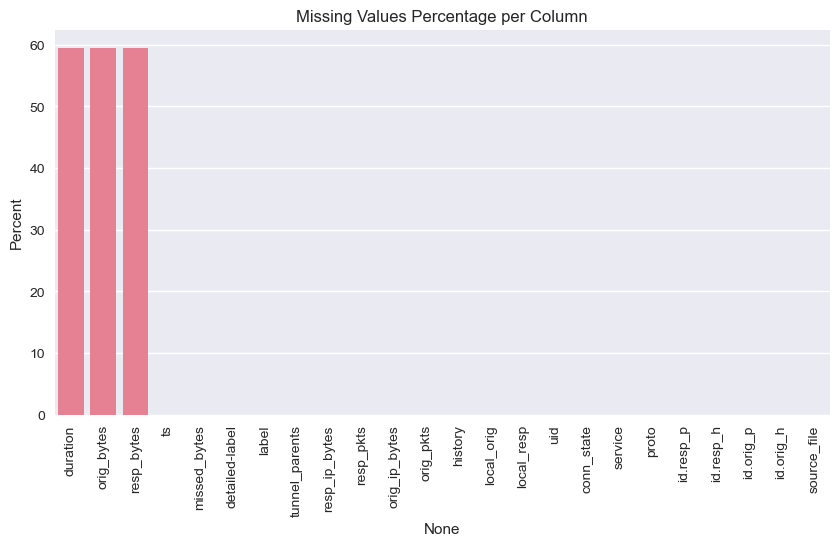

In [301]:
# Missing values summary
missing = df.isnull().sum().sort_values(ascending=False)
missing_percent = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({'MissingValues': missing, 'Percent': missing_percent})
display(missing_df[missing_df.MissingValues > 0])

# Visualize missing values
plt.figure(figsize=(10,5))
sns.barplot(x=missing_df.index, y=missing_df['Percent'])
plt.xticks(rotation=90)
plt.title("Missing Values Percentage per Column")
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Target value Distribution</h3>
</div>

label
Malicious    8222
Benign       2181
Name: count, dtype: int64


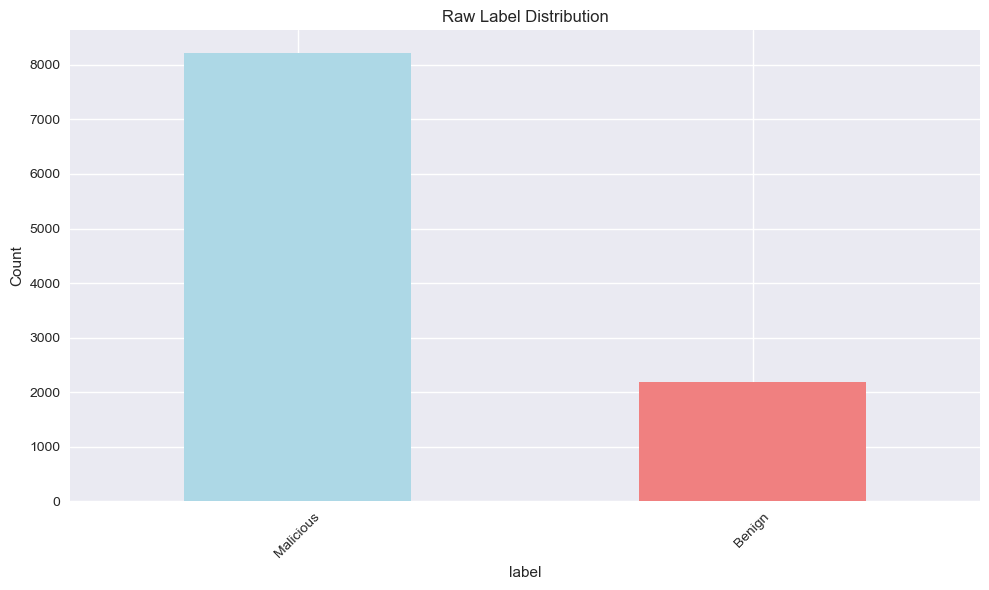

In [303]:
label_counts = df['label'].value_counts()
print(label_counts)

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Raw Label Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Histograms for numerical features</h3>
</div>

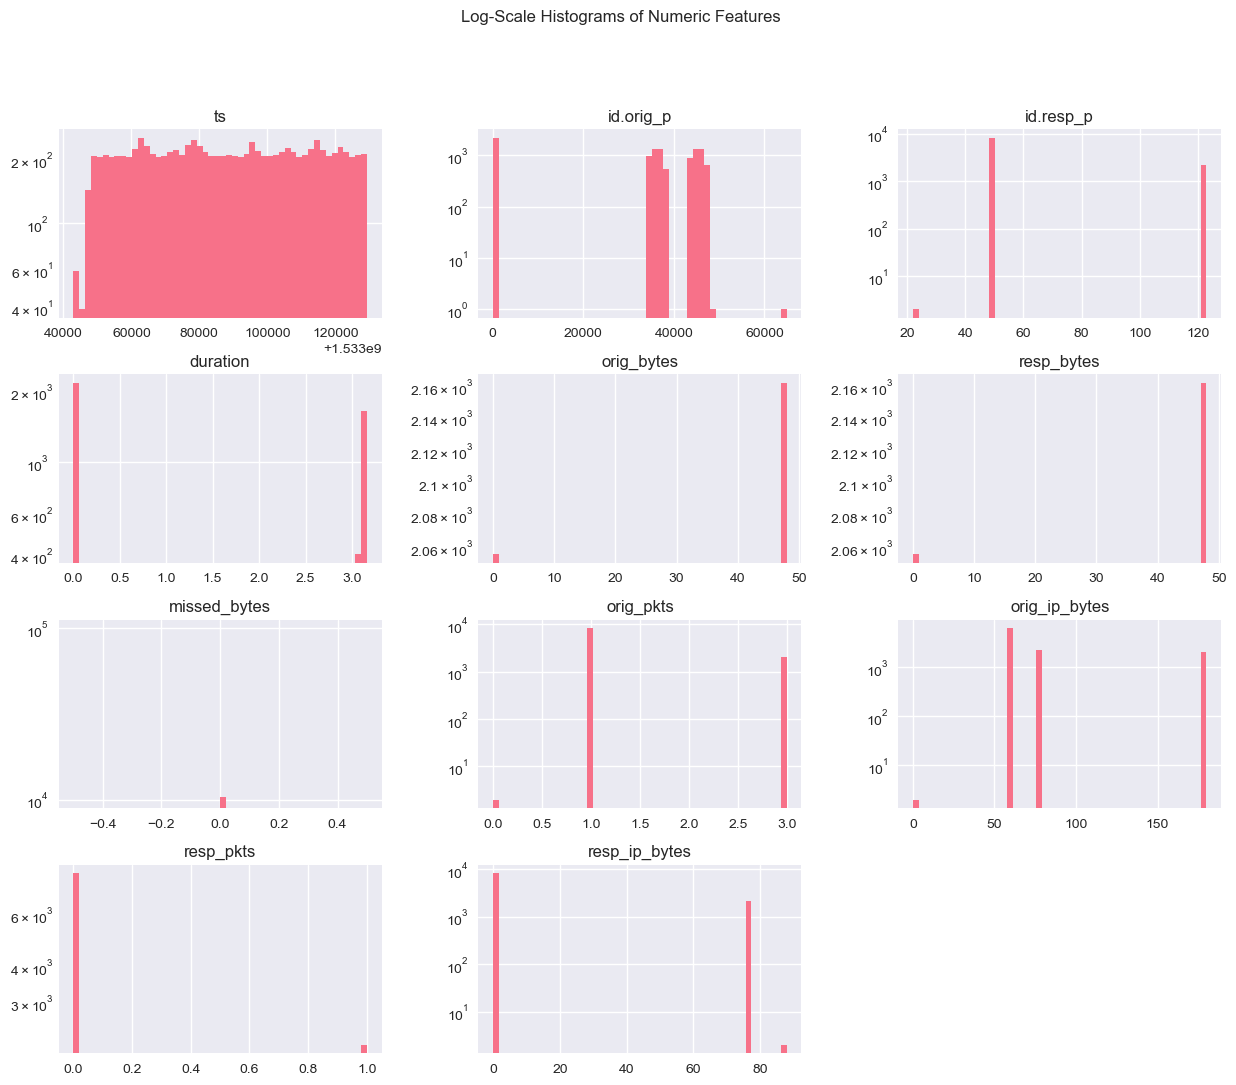

In [305]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols].hist(figsize=(15, 12), bins=50, log=True)
plt.suptitle("Log-Scale Histograms of Numeric Features")
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Correlation Heatmap</h3>
</div>

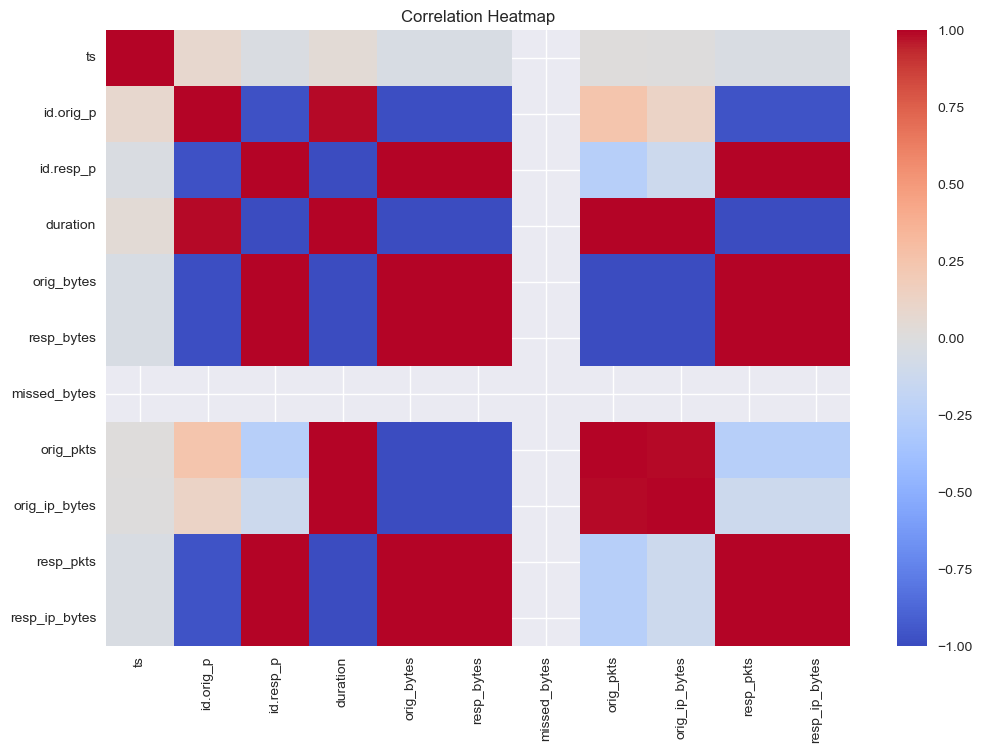

In [307]:
plt.figure(figsize=(12,8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Bivariate Analysis: Boxplots by Label</h3>
</div>

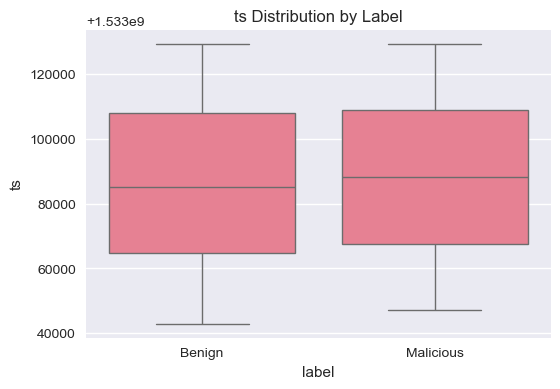

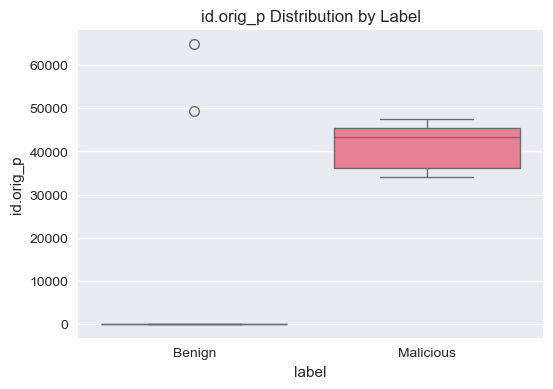

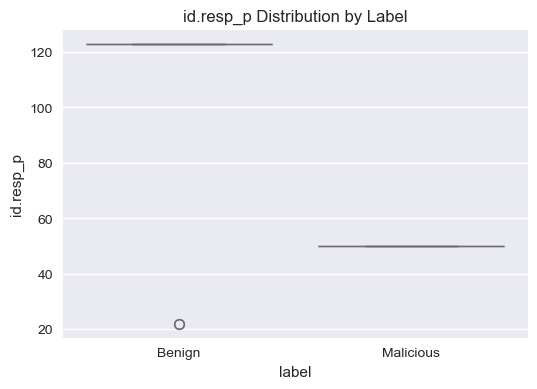

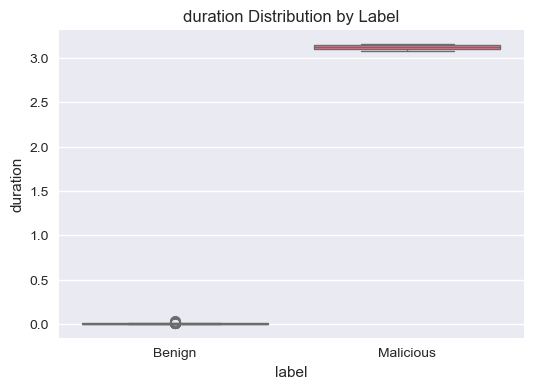

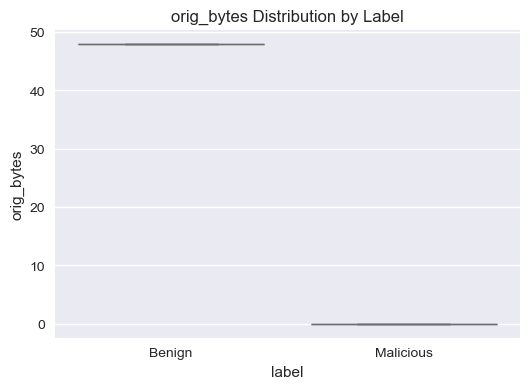

In [309]:
for col in numeric_cols[:5]:  # first 5 numeric features
    plt.figure(figsize=(6,4))
    sns.boxplot(x='label', y=col, data=df)
    plt.title(f"{col} Distribution by Label")
    plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Outlier detection</h3>
</div>

In [311]:
for col in numeric_cols:
    q1, q3 = np.percentile(df[col].dropna(), [25, 75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    outlier_count = ((df[col] < lower) | (df[col] > upper)).sum()
    print(f"{col}: {outlier_count} outliers")

ts: 0 outliers
id.orig_p: 2180 outliers
id.resp_p: 2181 outliers
duration: 0 outliers
orig_bytes: 0 outliers
resp_bytes: 0 outliers
missed_bytes: 0 outliers
orig_pkts: 2058 outliers
orig_ip_bytes: 2058 outliers
resp_pkts: 2164 outliers
resp_ip_bytes: 2164 outliers


<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Data Cleaning and Preparation</h1>
</div>

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Handling missing values</h3>
</div>

In [314]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

In [315]:
for col in numeric_cols:
    if col in df.columns:
        print(f"Converting {col} to numeric...")
        df[col] = pd.to_numeric(df[col], errors='coerce')
        missing_before = df[col].isnull().sum()
        df[col] = df[col].fillna(0)
        missing_after = df[col].isnull().sum()
        print(f"    Missing values: {missing_before} -> {missing_after}")

Converting ts to numeric...
    Missing values: 0 -> 0
Converting id.orig_p to numeric...
    Missing values: 0 -> 0
Converting id.resp_p to numeric...
    Missing values: 0 -> 0
Converting duration to numeric...
    Missing values: 6185 -> 0
Converting orig_bytes to numeric...
    Missing values: 6185 -> 0
Converting resp_bytes to numeric...
    Missing values: 6185 -> 0
Converting missed_bytes to numeric...
    Missing values: 0 -> 0
Converting orig_pkts to numeric...
    Missing values: 0 -> 0
Converting orig_ip_bytes to numeric...
    Missing values: 0 -> 0
Converting resp_pkts to numeric...
    Missing values: 0 -> 0
Converting resp_ip_bytes to numeric...
    Missing values: 0 -> 0


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Feature Engineering</h3>
</div>

In [317]:
if {'TotalBytes', 'TotalPackets', 'Duration'}.issubset(df.columns):
    df['BytesPerPacket'] = df['TotalBytes'] / (df['TotalPackets'] + 1)
    df['PacketsPerSecond'] = df['TotalPackets'] / (df['Duration'] + 1e-6)

# Encode Protocols
if 'Protocol' in df.columns:
    df = pd.get_dummies(df, columns=['Protocol'], drop_first=True)

# Convert IP addresses to numeric
import ipaddress
def ip_to_int(ip):
    try:
        return int(ipaddress.IPv4Address(ip))
    except:
        return None

for col in ['SourceIP','DestinationIP']:
    if col in df.columns:
        df[col+'_int'] = df[col].apply(ip_to_int)

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Convert timestamp to datetime</h3>
</div>

In [319]:
print("Converting timestamps")
df['timestamp'] = pd.to_datetime(df['ts'], unit='s', errors='coerce')
invalid_timestamps = df['timestamp'].isnull().sum()
print(f"    Invalid timestamps: {invalid_timestamps}")

# Adding temporal features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()
print("Added hour and day_of_week features")

Converting timestamps
    Invalid timestamps: 0
Added hour and day_of_week features


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Handling IP addresses and ports</h3>
</div>

In [321]:
print("Processing origin IP addresses...")
df['is_private_orig'] = df['id.orig_h'].apply(lambda x: 
    ipaddress.ip_address(x).is_private if pd.notna(x) else False)

print("Processing response IP addresses...")
df['is_private_resp'] = df['id.resp_h'].apply(lambda x: 
    ipaddress.ip_address(x).is_private if pd.notna(x) else False)

Processing origin IP addresses...
Processing response IP addresses...


In [322]:
# Categorize ports into common service types
def categorize_port(port):
    try:
        port = int(port)
        if port <= 1024:
            return 'well_known'
        elif port <= 49151:
            return 'registered'
        else:
            return 'dynamic'
    except:
        return 'unknown'

print("Categorizing origin ports...")
df['orig_port_category'] = df['id.orig_p'].apply(categorize_port)
    
print("Categorizing response ports...")
df['resp_port_category'] = df['id.resp_p'].apply(categorize_port)

Categorizing origin ports...
Categorizing response ports...


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Handling duplicates</h3>
</div>

In [324]:
duplicates_before = df.duplicated().sum()
df = df.drop_duplicates()
duplicates_after = df.duplicated().sum()
print(f"Removed {duplicates_before - duplicates_after} duplicate rows")

Removed 0 duplicate rows


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Class Imbalance Handling</h3>
</div>

In [326]:
nan_summary = df.isna().sum()
print(nan_summary[nan_summary > 0])
X = df[numeric_cols]
y = df['label']

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

print("\n\nBefore SMOTE:", y.value_counts())
print("\n\nAfter SMOTE:", y_res.value_counts())

df = pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.Series(y_res, name='label')], axis=1)

print("\n\nShape after SMOTE:", df.shape)
print("Class distribution after SMOTE:\n", df['label'].value_counts())


Series([], dtype: int64)


Before SMOTE: label
Malicious    8222
Benign       2181
Name: count, dtype: int64


After SMOTE: label
Benign       8222
Malicious    8222
Name: count, dtype: int64


Shape after SMOTE: (16444, 12)
Class distribution after SMOTE:
 label
Benign       8222
Malicious    8222
Name: count, dtype: int64


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Label encoding categorical values</h3>
</div>

In [328]:
# Identify columns with only 1 unique value
single_value_cols = [col for col in df.columns if df[col].nunique() <= 1]

print("Dropping columns with a single unique value:", single_value_cols)

# Drop these columns
df = df.drop(columns=single_value_cols)

Dropping columns with a single unique value: ['missed_bytes']


In [329]:
encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le
    print(f"Encoded column '{col}' with {len(le.classes_)} classes")

Encoded column 'label' with 2 classes


<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Post Cleanup Analysis and Processing</h1>
</div>

In [331]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Missing Values</h3>
</div>

In [333]:
missing_after = df.isnull().sum()
print("Missing values after cleanup:")
print(missing_after[missing_after > 0])

Missing values after cleanup:
Series([], dtype: int64)


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Negative values check</h3>
</div>

In [335]:
for col in numeric_cols:
    if col in df.columns:
        negative_count = (df[col] < 0).sum()
        if negative_count > 0:
            print(f"{col}: {negative_count} negative values")
        else:
            print(f"{col}: No negative values")

ts: No negative values
id.orig_p: No negative values
id.resp_p: No negative values
duration: No negative values
orig_bytes: No negative values
resp_bytes: No negative values
orig_pkts: No negative values
orig_ip_bytes: No negative values
resp_pkts: No negative values
resp_ip_bytes: No negative values
label: No negative values


<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Target value distribution</h3>
</div>

label
0    8222
1    8222
Name: count, dtype: int64


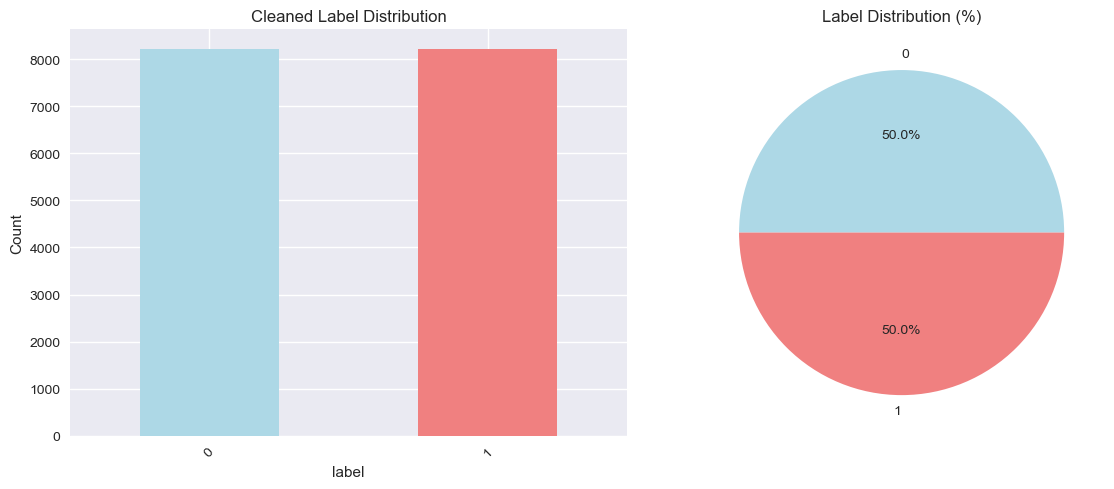

Class imbalance ratio: 1.00


In [337]:
label_counts = df['label'].value_counts()
print(label_counts)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
label_counts.plot(kind='bar', color=['lightblue', 'lightcoral'])
plt.title('Cleaned Label Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', 
        colors=['lightblue', 'lightcoral'])
plt.title('Label Distribution (%)')
plt.tight_layout()
plt.savefig('cleaned_label_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Class imbalance ratio: {label_counts[1] / label_counts[0]:.2f}")

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Traffic statistics</h3>
</div>

Traffic Statistics Summary:
           duration    orig_bytes    resp_bytes     orig_pkts     resp_pkts
count  16444.000000  16444.000000  16444.000000  16444.000000  16444.000000
mean       0.391657     23.809656     23.809656      1.249757      0.494162
std        1.031617     23.962481     23.962481      0.661872      0.499981
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000      1.000000      0.000000
50%        0.001745      0.000000      0.000000      1.000000      0.000000
75%        0.004449     48.000000     48.000000      1.000000      1.000000
max        3.160201     48.000000     48.000000      3.000000      1.000000


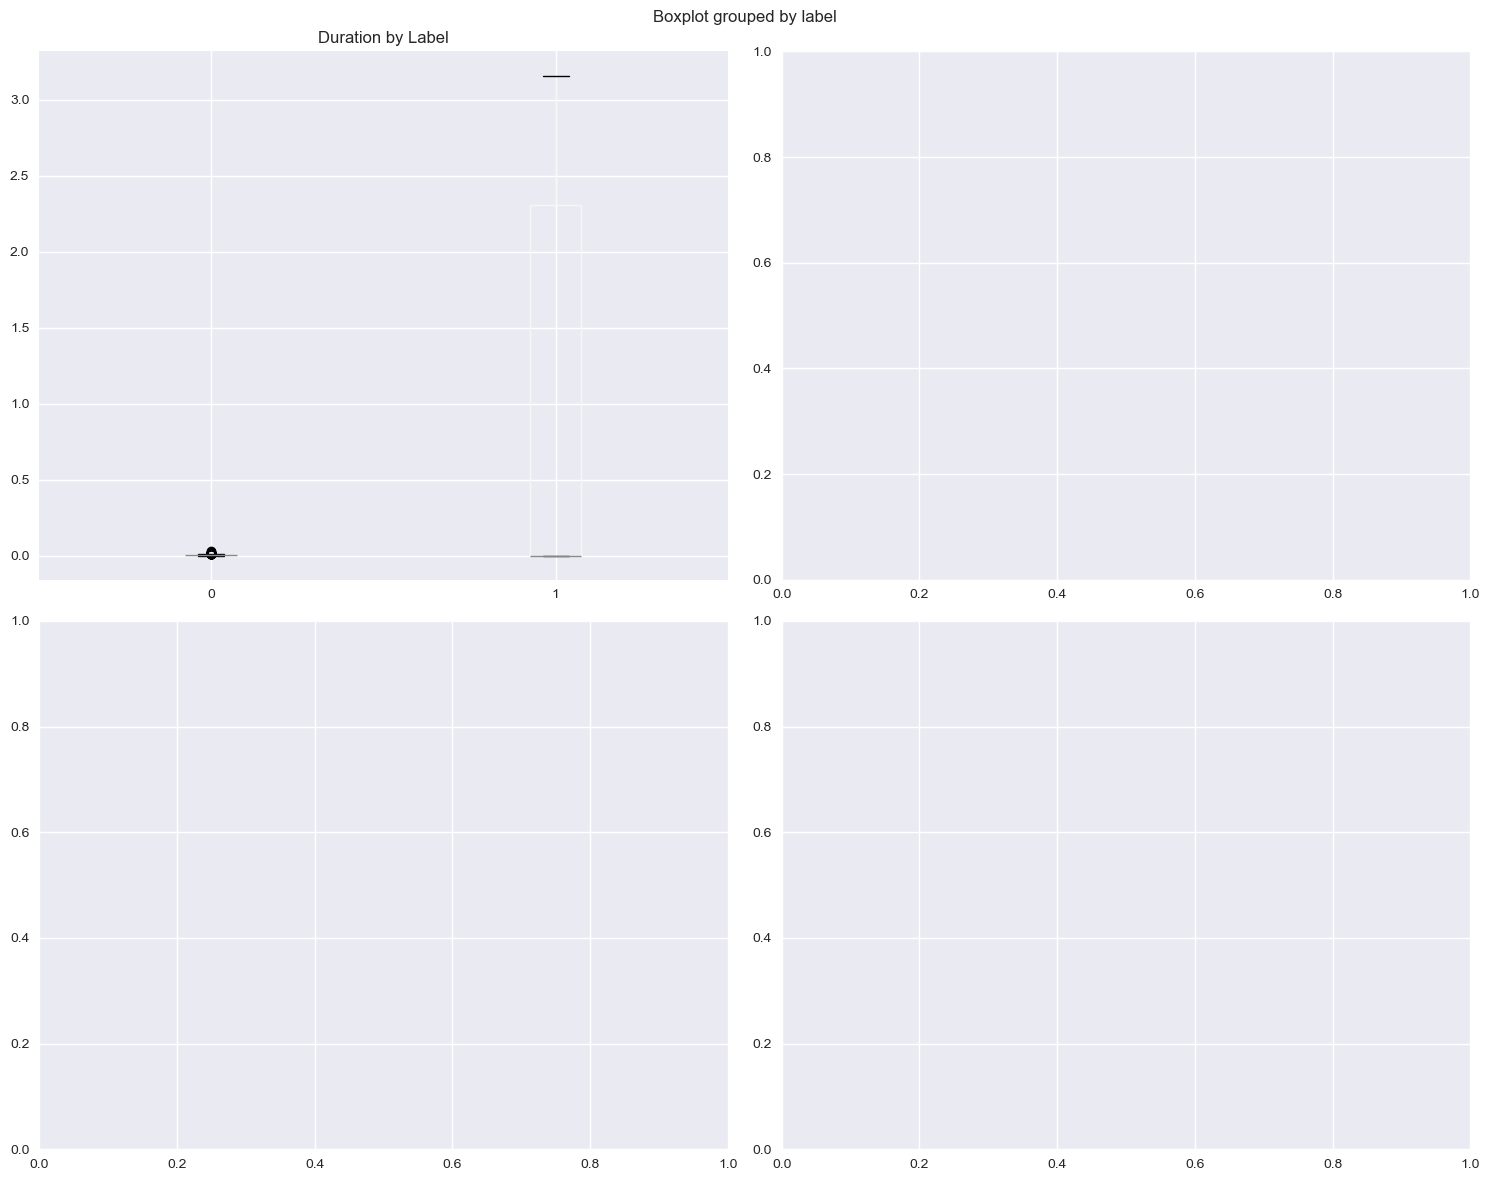

In [339]:
traffic_cols = ['duration', 'orig_bytes', 'resp_bytes', 'total_bytes', 'orig_pkts', 'resp_pkts', 'total_packets', 'bytes_per_packet']

available_traffic_cols = [col for col in traffic_cols if col in df.columns]
if available_traffic_cols:
    print("Traffic Statistics Summary:")
    print(df[available_traffic_cols].describe())
    
    # Plot traffic statistics by label
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Traffic Statistics by Label (Cleaned)', fontsize=16)
    
    for i, col in enumerate(['duration', 'total_bytes', 'total_packets', 'bytes_per_packet']):
        if col in df.columns:
            row, col_idx = i // 2, i % 2
            df.boxplot(column=col, by='label', ax=axes[row, col_idx])
            axes[row, col_idx].set_title(f'{col.title()} by Label')
            axes[row, col_idx].set_xlabel('')
    plt.tight_layout()
    plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Correlation analysis</h3>
</div>

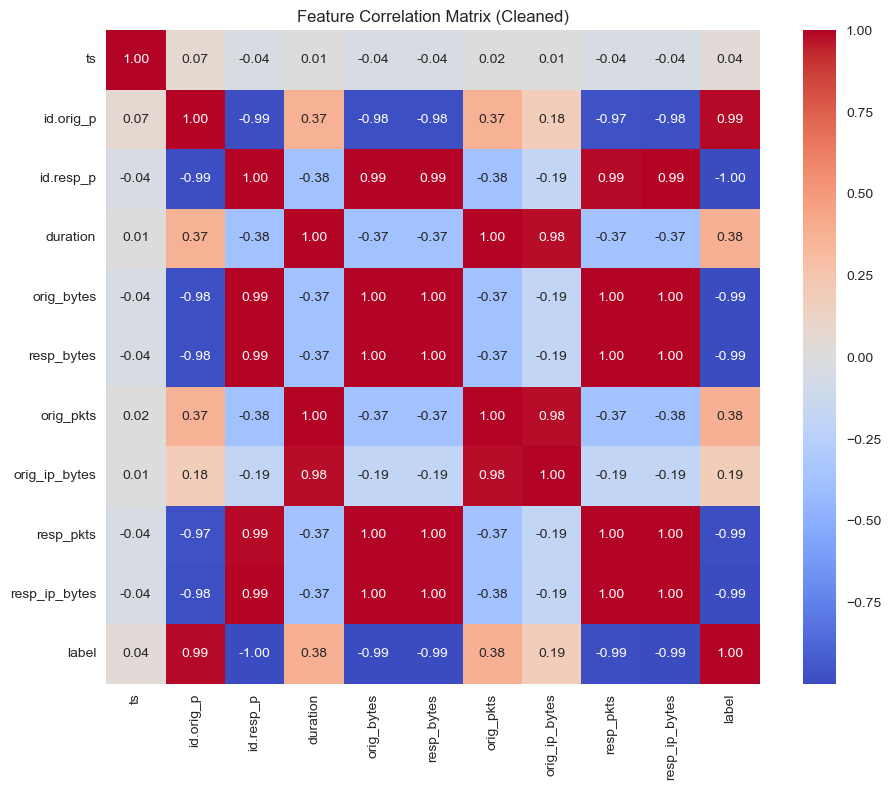

In [341]:
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
plt.title('Feature Correlation Matrix (Cleaned)')
plt.tight_layout()
plt.show()

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Scaling and Train-Test Split</h3>
</div>

In [343]:
X = df.drop(columns=['label'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_res)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<div style="background: #c6eed6; border: 1px solid #6ad194; padding: 10px 20px">
    <h3>Dimensionality Reduction (PCA)</h3>
</div>

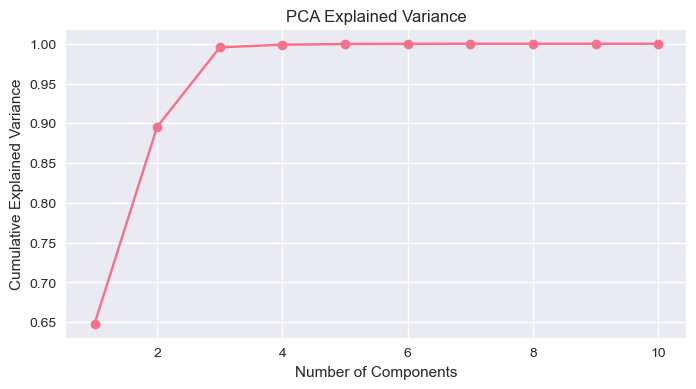

Number of components explaining 95% variance: 3


In [345]:
# # PCA: fit on training, transform both train and test
# pca = PCA()
# X_train_pca_full = pca.fit_transform(X_train_scaled)
# X_test_pca_full = pca.transform(X_test_scaled)

# # Explained variance
# explained_variance = pca.explained_variance_ratio_
# cumulative_variance = np.cumsum(explained_variance)

# plt.figure(figsize=(8,4))
# plt.plot(range(1, len(explained_variance)+1), cumulative_variance, marker='o')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('PCA Explained Variance')
# plt.grid(True)
# plt.show()

# # Pick components explaining 95% variance
# n_components = np.argmax(cumulative_variance >= 0.95) + 1
# print(f"Number of components explaining 95% variance: {n_components}")

# # Fit PCA again with selected components
# pca_final = PCA(n_components=n_components)
# X_train_pca = pca_final.fit_transform(X_train_scaled)
# X_test_pca = pca_final.transform(X_test_scaled)


<div style="background: #fcf9be; border: 1px solid #f0e61f; padding: 10px 20px">
    <h1>Cross Validation</h1>
    <ul>
        <li>SVM</li>
        <li>XGBoost</li>
        <li>Random Forest</li>
        <li>LiteGBM</li>
        <li>Extra Trees</li>
        <li>Gradient Boost Trees</li>
    </ul>
</div>

In [392]:
# Define models
models = {
    # "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=200, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(n_estimators=100, random_state=42)
}

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, model in models.items():
    print(f"\nTraining {name} with PCA features...")
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    results.append({
        'Model': name,
        'Mean Accuracy': np.mean(scores),
        'Std Dev': np.std(scores)
    })

results_df = pd.DataFrame(results).sort_values(by='Mean Accuracy', ascending=False)
results_df


Training Random Forest with PCA features...

Training Extra Trees with PCA features...

Training Gradient Boosting with PCA features...

Training XGBoost with PCA features...

Training LightGBM with PCA features...
[LightGBM] [Info] Number of positive: 5263, number of negative: 5261
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 10524, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500095 -> initscore=0.000380
[LightGBM] [Info] Start training from score 0.000380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [03:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [03:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [03:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [03:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

,Model,Mean Accuracy,Std Dev
0,Random Forest,1.000000,0.000000
1,Extra Trees,1.000000,0.000000
2,Gradient Boosting,1.000000,0.000000
4,LightGBM,1.000000,0.000000
3,XGBoost,0.999924,0.000152
